In [1]:
    # def test(model, device, test_loader):
#     test_losses_l1 = []
#     test_acc_l1 = []
#     model.eval()
#     test_loss = 0
#     correct = 0
#     criterion= nn.CrossEntropyLoss().to(device)
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += criterion(output, target).item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)
#     test_losses_l1.append(test_loss)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

#     test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [2]:
# def train(model, device, train_loader, optimizer, epoch):
#     train_losses = []
#     train_acc = []

#     model.train()

#     pbar = tqdm(train_loader)
#     correct = 0
#     processed = 0
#     criterion= nn.CrossEntropyLoss().to(device)
#     for batch_idx, (data, target) in enumerate(pbar):


#         data, target = data.to(device), target.to(device)

#         # Init
#         optimizer.zero_grad()

#         # Predict
#         y_pred = model(data)

#         # Calculate loss
#         loss  = criterion(y_pred, target)


#         train_losses.append(loss)



#          #Backpropagation
#         loss.backward()
#         optimizer.step()

#         # Update pbar-tqdm

#         pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         processed += len(data)

#         pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
#     train_acc.append(100*correct/processed)


In [3]:
#torch.cuda.empty_cache()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch import nn
import torchvision
import torch
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

import time

In [5]:
import sklearn.metrics

In [6]:
from torchvision.models import resnet

In [7]:
from typing import List

import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import math

class CustomConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(CustomConvLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return nn.functional.conv2d(x, self.weight, bias=self.bias, stride=1, padding=self.kernel_size//2)




def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) #- исходный слой
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.conv1 = CustomConvLayer(in_channels=3, out_channels=64, kernel_size=3)


        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

    return model


In [8]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# custom_kernel = np.array([[1.,1.,1.], [1.,-8.,1.], [1.,1.,1.]]) #изменение входного слоя сети на суммму ядер b_n
# custom_conv_layer = CustomConvLayer(in_channels=3, out_channels=64, kernel_size=3)
# custom_conv_layer.weight.data = torch.Tensor(np.stack([custom_kernel]*64, axis=0))
model = resnet18()
model = model.to(device)

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [11]:
learning_rate = 0.01
gamma = 0.3
step_size =1
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)
scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def plotting(train_list, valid_list, name_metrics):
    plt.figure(figsize=(10, 10))
    plt.xlabel("Epoch")
    plt.ylabel(name_metrics)
    plt.title("relationship between Epoch and {}".format(name_metrics))
    plt.plot(np.arange(1, len(train_list) + 1), train_list, "ro-.", label="train")
    plt.plot(np.arange(1, len(valid_list) +  1), valid_list, "bo-.", label="valid")
    plt.legend()
    plt.show()

In [13]:
#testing working def plotting

#train_list = (2.6111857891082764, 2.47836971282959, 2.4449033737182617, 2.6071555614471436, 2.490676164627075, )
#valid_list = (1.4395322799682617, 1.3606643676757812, 1.6594208478927612, 1.4870997667312622, 1.2268149852752686)
#plotting(train_list, valid_list, "Loss")

In [14]:
def train(model, device, dataloader, optimizer, num_epoch = 10):

    criterion = nn.CrossEntropyLoss().to(device)

    model.train()

    sum_loss = 0
    sum_accuracy = 0

    for index, (data, targets) in enumerate(dataloader):

        data = data.to(device)
        targets = targets.to(device)

        output = model(data)
        loss = criterion(output, targets)

        sum_loss += loss.item() * data.size(0)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = targets.size(0)
        _, predicted = torch.max(output.data, 1)
        correct =  (predicted == targets).sum().item()
        sum_accuracy += correct

    epoch_loss = sum_loss / len(dataloader.dataset)

    epoch_accuracy = sum_accuracy / len(dataloader.dataset)

    print("Train: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))

    return epoch_loss, epoch_accuracy


In [15]:
def validate(model, device, dataloader, optimazer, num_epoch):

    criterion = nn.CrossEntropyLoss().to(device)

    model.eval()
    with torch.no_grad():

        sum_loss = 0
        sum_accuracy = 0

        for index, (data, targets) in enumerate(dataloader):

            data = data.to(device)
            targets = targets.to(device)

            output = model(data)
            loss = criterion(output, targets)

            sum_loss += loss.item() * data.size(0)

            total = targets.size(0)
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == targets).sum().item()
            sum_accuracy += correct

    epoch_loss = sum_loss / len(dataloader.dataset)

    epoch_accuracy = sum_accuracy / len(dataloader.dataset)

    print("Valid: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))

    return epoch_loss, epoch_accuracy


In [16]:

        #print("Validation: ", "Loss {}  Accuracy {} \n".format(loss_valid_list[epoch], accuracy_valid_list[epoch]))

    #print(len(loss_train_list), "loss_train_list")
    #print(loss_train_list)
    #plotting(loss_train_list, loss_valid_list, "Loss")
    #plotting(accuracy_train_list, accuracy_valid_list, "Accuracy")

In [17]:
batch_size = 64
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([#transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                  transforms.Normalize(*stats,inplace=True)])

valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = train_tfms)
trainset, validset, garbage = data.random_split(trainset, [45000, 5000, 0])


trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers = 2)
validloader = torch.utils.data.DataLoader(validset, batch_size = batch_size, shuffle=True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download = True, transform = valid_tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size = 10000, shuffle = False, num_workers = 2)

dataloader = {"train": trainloader, "valid": validloader, "tests": testloader}
#dataloader = {"train": trainloader, "tests": testloader}

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:13<00:00, 12863057.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
# data = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = train_tfms)
# data

In [19]:
# dataiter = iter(data)
# dataiter

In [20]:
# img, label = next(dataiter)

In [21]:
# k = 0
# for img, label in dataiter:
#     if k == 2:
#         break
#     else:
#         k+=1
#     print(img, label)

In [22]:
# img_x, img_y, img_z = img

In [23]:
# img_x_np = img_x.numpy()
# img_x_np += img_x_np

In [24]:
# img = np.array([img_x_np, img_y.numpy(), img_z.numpy()])
# img = torch.tensor(img)
# img

In [25]:
# img = torch.tensor(img)

In [26]:
# img

In [27]:
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

In [28]:
#сделано        # В функции train оставить только сам train(убрать if на "train" и "valid"), а также дописать функцию validate -
                # которая на каждой эпохи проверяет нет ли переобучения модели


#сделано        # Также теперь каждая функция train и validate должны выдавать список значений - loss и accuracy, по которы можно будет
                # потом построить график

In [29]:
loss_train_list = []
loss_valid_list = []
accuracy_train_list = []
accuracy_valid_list = []

num_epoch = 150

print("Total Epoch {}\n".format(num_epoch))
all_time = time.time()

for epoch in range(num_epoch):

    start_time = time.time()

    print("Size Epoch {}\n".format(epoch + 1))

    loss_train, accuracy_train = train(model, device, dataloader["train"], optimizer, epoch)

    loss_train_list.append(loss_train)
    accuracy_train_list.append(accuracy_train)

    loss_valid, accuracy_valid = validate(model, device, dataloader["valid"], optimizer, epoch)

    loss_valid_list.append(loss_valid)
    accuracy_valid_list.append(accuracy_valid)

    print("--- %s seconds --- \n" % (time.time() - start_time))

    scheduler.step()

result_time = time.time() - all_time

print("Total time training model: {} min {} sec".format(result_time // 60, result_time % 60))

Total Epoch 150

Size Epoch 1

Train:  Loss 1.4693780136320327  Accuracy 0.4689333333333333 

Valid:  Loss 1.6055550155639648  Accuracy 0.4764 

--- 46.945181369781494 seconds --- 

Size Epoch 2

Train:  Loss 0.8435343178007337  Accuracy 0.7013111111111111 

Valid:  Loss 0.7793334986686706  Accuracy 0.7198 

--- 40.92998194694519 seconds --- 

Size Epoch 3

Train:  Loss 0.644351261138916  Accuracy 0.7756444444444445 

Valid:  Loss 0.7098257420539856  Accuracy 0.7512 

--- 40.879796743392944 seconds --- 

Size Epoch 4

Train:  Loss 0.5692422336525387  Accuracy 0.8044 

Valid:  Loss 0.6790003471374512  Accuracy 0.7624 

--- 41.809146881103516 seconds --- 

Size Epoch 5

Train:  Loss 0.5457702607048882  Accuracy 0.8135111111111111 

Valid:  Loss 0.6783488243103027  Accuracy 0.7632 

--- 41.447983503341675 seconds --- 

Size Epoch 6

Train:  Loss 0.5368124778853522  Accuracy 0.8155111111111111 

Valid:  Loss 0.6766335910797119  Accuracy 0.7612 

--- 41.127747774124146 seconds --- 

Size Ep

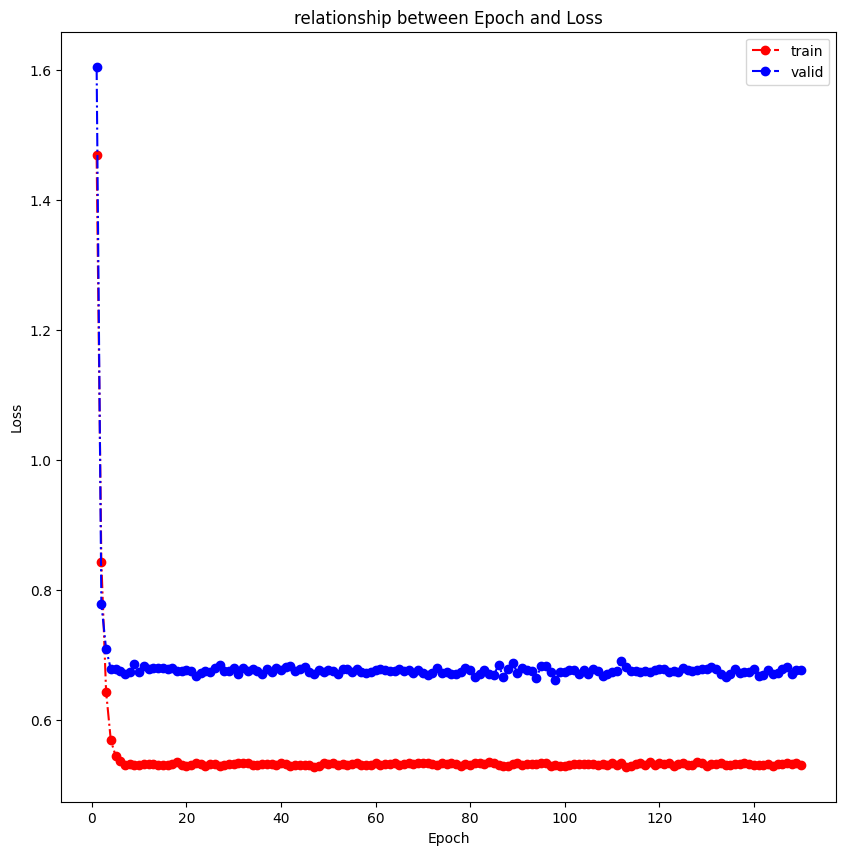

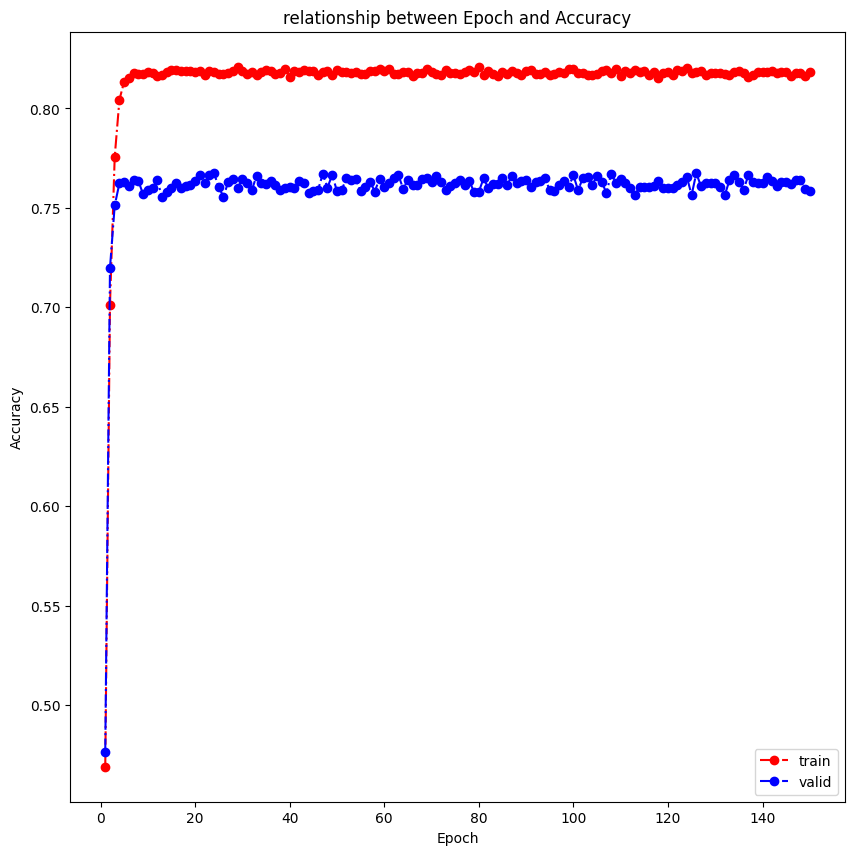

In [30]:
# График зависимостей Loss и Accuracy от train и validate выборок

plotting(loss_train_list, loss_valid_list, "Loss")
plotting(accuracy_train_list, accuracy_valid_list, "Accuracy")

In [31]:
for i in range(2):
    max_accuracy = max(accuracy_valid_list)
    #max_accuracy = max(accuracy_test_list)
    index = accuracy_valid_list.index(max_accuracy)
    #index = accuracy_test_list.index(max_accuracy)
    print("Максимальное значение Accuracy на validation: {}     на эпохе {}\n".format(max_accuracy, index + 1))

    #accuracy_valid_list[index] = 0

Максимальное значение Accuracy на validation: 0.7674     на эпохе 24

Максимальное значение Accuracy на validation: 0.7674     на эпохе 24



In [32]:
!pip install scikit-plot
from scikitplot.metrics import plot_roc_curve

#from sklearn.metrics import plot_roc_curve
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc, roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
dataloader = dataloader["tests"]

In [34]:

start_time = time.time()
i = 0
criterion = nn.CrossEntropyLoss().to(device)

model.eval()
with torch.no_grad():

    sum_loss = 0
    sum_accuracy = 0

    for index, (data, targets) in enumerate(dataloader):
        i += 1
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)
        loss = criterion(output, targets)

        sum_loss += loss.item() * data.size(0)

        total = targets.size(0)

        _, predicted = torch.max(torch.softmax(output.data, 1), 1)
        # print(output.data)
        # print(torch.softmax(output.data, 1))
        # probas = torch.softmax(output.data, 1)
        # print(probas.data)
        #print(type(probas.detach().cpu().numpy()),'  ',probas.to()[0] , "\n", type(targets), '  ', targets.to()[0])
        correct = (predicted == targets).sum().item()
        sum_accuracy += correct

        see_softmax = torch.softmax(output.data, 1).detach().cpu().numpy()
        #print(output.data)
        #see_predicted = predicted.detach().cpu().numpy()
        see_predicted = predicted
        #print(see_predicted, "\n")

        #print(torch.softmax(see_predicted.data).detach().cpu().numpy())
        see_targets = targets.detach().cpu().numpy()
        #print(see_targets, "\n")
        for num_class in range(10):
            res = roc_auc_score(targets.detach().cpu().numpy(), see_softmax, multi_class = "ovr")
            #res = roc_auc_score(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), multi_class = "ovr")
            #tpr, fpr, threshold = roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), pos_label =num_class)

            #print("tpr: ", tpr, "\n")
            #print("fpr: ", fpr, "\n")
            #print(res, "\n")

        #RocCurveDisplay.from_estimator()
        #skplt.metrics.plot_roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), multi_class="ovr")

epoch_loss = sum_loss / len(dataloader.dataset)

epoch_accuracy = sum_accuracy / len(dataloader.dataset)

print("Test: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))
print(i)

Test:  Loss 0.6836246848106384  Accuracy 0.7561 

1


In [35]:
predicted = predicted.detach().cpu().numpy() # имеет размер 10000

In [36]:
targets = targets.detach().cpu().numpy() # имеет размер 10000

In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn import metrics

def plot_roc_log(y_true, y_scores):
  y_scores = label_binarize(y_scores, classes = np.arange(10))
  y_one_hot = label_binarize(y_true, classes = np.arange(10))
  fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
  fpr1 = []
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.figure(figsize=(5, 5))
  plt.title('Receiver Operating Characteristic')
  plt.semilogx(fpr, tpr)
  ax = plt.gca()
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.grid()
  plt.legend(loc="lower right")
  plt.show()

<ipython-input-37-ccea393794f3>:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0.0, 1.0])


<Figure size 640x480 with 0 Axes>

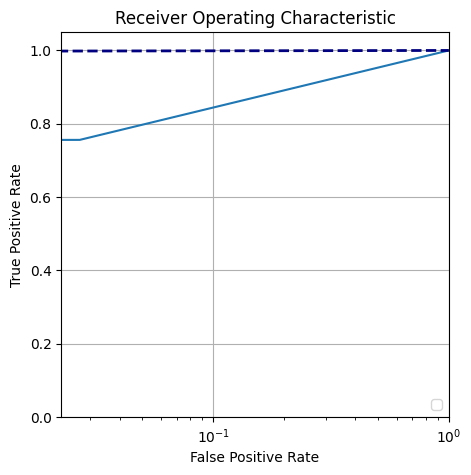

In [38]:
plot_roc_log(targets, predicted)

In [ ]:
def plot_roc_log(y_true, y_scores):
  y_one_hot = label_binarize(y_true, classes = np.arange(10))
  y_scores = label_binarize(y_scores, classes = np.arange(10))
  print(len(y_one_hot), len(y_scores))
  print(len(y_one_hot.ravel()), len(y_scores.ravel()))
  fpr, tpr, threshold = roc_curve(y_one_hot.ravel(), y_scores.ravel())
  print(fpr)
  fpr1 = []
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.figure(figsize=(10, 10))
  plt.title('Receiver Operating Characteristic')
  plt.semilogx(fpr, tpr)
  ax = plt.gca()
  line = ax.lines[0]
  x = line.get_xdata()
  y = line.get_ydata()
  x = list(x)
  k = []
  for i in x:
    if i<0.0101 and i>=0.01:
      k.append(i)
      l = min(k)
      ind = x.index(l)
      #answ = y[x]
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')
      plt.grid()
      plt.legend(loc="lower right")
      plt.show()
      return y[ind]

In [ ]:
def test(model, device, dataloader):
    start_time = time.time()
    i = 0
    criterion = nn.CrossEntropyLoss().to(device)

    model.eval()
    with torch.no_grad():

        sum_loss = 0
        sum_accuracy = 0

        for index, (data, targets) in enumerate(dataloader):
            i += 1
            data = data.to(device)
            targets = targets.to(device)

            output = model(data)
            loss = criterion(output, targets)

            sum_loss += loss.item() * data.size(0)

            total = targets.size(0)

            _, predicted = torch.max(torch.softmax(output.data, 1), 1)
            # print(output.data)
            # print(torch.softmax(output.data, 1))
            # probas = torch.softmax(output.data, 1)
            # print(probas.data)
            #print(type(probas.detach().cpu().numpy()),'  ',probas.to()[0] , "\n", type(targets), '  ', targets.to()[0])
            correct = (predicted == targets).sum().item()
            sum_accuracy += correct
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            #for num_class in range(10):
                #res = roc_auc_score(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(),multi_class = "ovr")
                #fpr[num_class], tpr[num_class], threshold = roc_curve(targets[:, i].detach().cpu().numpy(), predicted[:, i].detach().cpu().numpy(), pos_label =num_class)
                #roc_auc[i] = auc(fpr[i], tpr[i])
                # print("tpr: ", fpr[num_class], "\n")
                # print("fpr: ", tpr[num_class], "\n")
                # #print(res, "\n")


            #skplt.metrics.plot_roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy())
    #print(fpr)
    epoch_loss = sum_loss / len(dataloader.dataset)

    epoch_accuracy = sum_accuracy / len(dataloader.dataset)

    print("Test: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))
    print(i)



    for i in range(10):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve') #% roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
test(model, device, dataloader["tests"])

TypeError: ignored

In [ ]:
dataloader = dataloader["tests"]

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
def plotting_roc(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve') #% roc_auc[i])

    plt.xscale('log')
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.xlim([10**(-2), 6*10**(-2)])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

7603 



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


tpr:  [0.         0.01644444 0.12444444 0.23766667 0.35333333 0.45188889
 0.55511111 0.67333333 0.78322222 0.88588889 1.        ] 

fpr:  [0.    0.86  0.878 0.886 0.894 0.898 0.902 0.917 0.923 0.97  1.   ] 



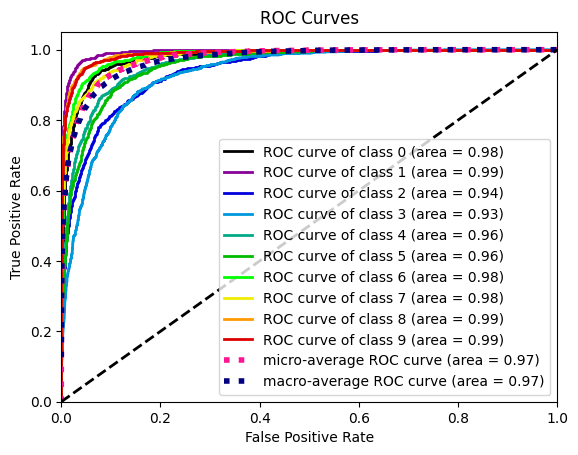

In [ ]:
# start_time = time.time()
# i = 0
# criterion = nn.CrossEntropyLoss().to(device)

# model.eval()
# with torch.no_grad():

#     sum_loss = 0
#     sum_accuracy = 0

#     for index, (data, targets) in enumerate(dataloader):
#         i += 1
#         data = data.to(device)
#         targets = targets.to(device)

#         output = model(data)
#         loss = criterion(output, targets)

#         sum_loss += loss.item() * data.size(0)

#         total = targets.size(0)

#         _, predicted = torch.max(torch.softmax(output.data, 1), 1)
#         probas = torch.softmax(output, 1)

#         #print(probas)
#         #print(output.data)
#         # print(torch.softmax(output.data, 1))
#         # probas = torch.softmax(output.data, 1)
#         # print(probas.data)
#         #print(type(probas.detach().cpu().numpy()),'  ',probas.to()[0] , "\n", type(targets), '  ', targets.to()[0])

#         correct = (predicted == targets).sum().item()

#         # попробую написать новую
#         incorrect = (predicted != targets).sum().item()

#         print(correct, "\n")
#         sum_accuracy += correct
#         fpr = dict()
#         tpr = dict()
#         roc_auc = dict()
#         tp = [predicted == targets]
#         for num_class in range(10):
#             #res = roc_auc_score(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(),multi_class = "ovr")
#             fpr[num_class], tpr[num_class], threshold = roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), pos_label =num_class)
#             roc_auc[num_class] = auc(fpr[num_class], tpr[num_class])
#             # print("tpr: ", fpr[num_class], "\n")
#             # print("fpr: ", tpr[num_class], "\n")
#             # #print(res, "\n")


#         skplt.metrics.plot_roc_curve(targets.detach().cpu().numpy(), probas.detach().cpu().numpy())





# #print(fpr)
# epoch_loss = sum_loss / len(dataloader.dataset)

# epoch_accuracy = sum_accuracy / len(dataloader.dataset)

# #print("Test: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))
# #print(i)
# correct_index = max(roc_auc, key=roc_auc.get)



# #plotting_roc(fpr[correct_index], tpr[correct_index])


# # plt.figure()
# # plt.plot(fpr[correct_index], tpr[correct_index], label='ROC curve') #% roc_auc[i])
# # plt.plot([0, 1], [0, 1], 'k--')
# # # plt.xlim([0.0, 1.0])
# # # plt.ylim([0.0, 1.05])
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver operating characteristic example')
# # plt.legend(loc="lower right")
# # plt.show()


# print("tpr: ", fpr[correct_index], "\n")
# print("fpr: ", tpr[correct_index], "\n")

In [ ]:
(predicted == targets).sum().item()

7603

In [ ]:
(predicted != targets).sum().item()

2397

In [ ]:
s = [targets.detach().cpu().numpy() == predicted.detach().cpu().numpy()]

In [ ]:
k = 0
j = 0
for i in s:
    if i == True:
        k += 1
    else:
        j += 1

k, j

ValueError: ignored

In [ ]:
result_conf_matrix = sklearn.metrics.confusion_matrix(predicted.detach().cpu().numpy(), targets.detach().cpu().numpy())
result_conf_matrix

array([[774,  17,  59,  14,  21,   4,   6,   9,  54,  29],
       [ 13, 861,   4,   3,   3,   4,   4,   3,  19,  58],
       [ 68,   4, 677,  79,  85,  57,  44,  39,  10,   6],
       [ 17,   5,  53, 591,  58, 187,  47,  39,  21,  12],
       [ 11,   2,  75,  54, 684,  35,  18,  55,   1,   4],
       [  6,   2,  43, 142,  31, 640,  17,  54,   1,   4],
       [ 14,  10,  57,  70,  52,  25, 856,   6,   5,   6],
       [ 11,   3,  13,  22,  56,  42,   4, 779,   3,   9],
       [ 55,  18,   8,  12,   7,   3,   3,   2, 866,  23],
       [ 31,  78,  11,  13,   3,   3,   1,  14,  20, 849]])

In [ ]:
# подсчёт tpr  и fpr по confusion matrix(для каждого класса) в итоге i-ое место в списке = i-ый класс
tpr_conf_matrix = [0 for i in range(10)]
fpr_conf_matrix = [0 for i in range(10)]


for i in range(10):
    tp = result_conf_matrix[i,i]
    fn = result_conf_matrix[i,:].sum() - tp
    fp = result_conf_matrix[:, i].sum() - result_conf_matrix[i,i]
    tn = result_conf_matrix.sum() - tp - fn - fp

    tpr_conf_matrix[i] = tp / (tp + fn)
    fpr_conf_matrix[i] = fp / (fp + tn)

tpr_conf_matrix, fpr_conf_matrix

In [ ]:
plotting_roc(fpr_conf_matrix, tpr_conf_matrix)

In [ ]:

start_time = time.time()
i = 0
criterion = nn.CrossEntropyLoss().to(device)

model.eval()
with torch.no_grad():

    sum_loss = 0
    sum_accuracy = 0

    for index, (data, targets) in enumerate(dataloader):
        i += 1
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)
        loss = criterion(output, targets)

        sum_loss += loss.item() * data.size(0)

        total = targets.size(0)

        _, predicted = torch.max(torch.softmax(output.data, 1), 1)
        # print(output.data)
        # print(torch.softmax(output.data, 1))
        # probas = torch.softmax(output.data, 1)
        # print(probas.data)
        #print(type(probas.detach().cpu().numpy()),'  ',probas.to()[0] , "\n", type(targets), '  ', targets.to()[0])
        correct = (predicted == targets).sum().item()
        sum_accuracy += correct

        see_softmax = torch.softmax(output.data, 1).detach().cpu().numpy()
        #print(output.data)
        #see_predicted = predicted.detach().cpu().numpy()
        see_predicted = predicted
        #print(see_predicted, "\n")

        #print(torch.softmax(see_predicted.data).detach().cpu().numpy())
        see_targets = targets.detach().cpu().numpy()
        #print(see_targets, "\n")
        for num_class in range(10):
            res = roc_auc_score(targets.detach().cpu().numpy(), see_softmax, multi_class = "ovr")
            #res = roc_auc_score(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), multi_class = "ovr")
            #tpr, fpr, threshold = roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), pos_label =num_class)

            #print("tpr: ", tpr, "\n")
            #print("fpr: ", fpr, "\n")
            #print(res, "\n")

        #RocCurveDisplay.from_estimator()
        #skplt.metrics.plot_roc_curve(targets.detach().cpu().numpy(), predicted.detach().cpu().numpy(), multi_class="ovr")

epoch_loss = sum_loss / len(dataloader.dataset)

epoch_accuracy = sum_accuracy / len(dataloader.dataset)

print("Test: ", "Loss {}  Accuracy {} \n".format(epoch_loss, epoch_accuracy))
print(i)

ValueError: ignored

In [ ]:
print(see_predicted.shape, see_predicted)
see_targets.shape, see_targets

torch.Size([10000]) tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')


((10000,), array([3, 8, 8, ..., 5, 1, 7]))

In [ ]:
see_softmax[0]

array([4.2987839e-04, 7.9465494e-04, 4.1556574e-04, 8.2035643e-01,
       2.7376626e-04, 1.6233958e-01, 6.7111617e-03, 1.7596294e-04,
       8.0400649e-03, 4.6294869e-04], dtype=float32)